In [89]:
import pickle
from sklearn.ensemble import VotingClassifier
import numpy as np
from scipy.sparse import load_npz
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
X_train = load_npz('../vectors/tfidf_lemma/X_train_tfidf.npz')
y_train = np.load('../vectors/tfidf_lemma/y_train.npy')

X_test = load_npz('../vectors/tfidf_lemma/X_test_tfidf.npz')
y_test = np.load('../vectors/tfidf_lemma/y_test.npy')

labels = ['0','1','2','3']

In [91]:
with open('../models_dump/SVM_CV50_T50.pkl', 'rb') as file:
    SVM = pickle.load(file)

with open('../models_dump/RF_CV51_T51.pkl', 'rb') as file:
    RF = pickle.load(file)

In [92]:
weights = {'RF': [1, 1, 1, 1], 'SVM': [2, 2, 2, 3]}

In [93]:
def get_weighted_probabilities(models, X, weights):
    probabilities = [model.predict_proba(X) * weight for (model, weight) in zip(models, weights.values())]
    return np.sum(probabilities, axis=0)

In [94]:
ensemble_proba = get_weighted_probabilities([SVM, RF], X_test, weights)

In [95]:
ensemble_model = VotingClassifier(estimators=[
    ('RF', RF),
    ('SVM', SVM)
], voting='soft', weights=weights)

In [96]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight={0: 0.0010416666666666667,
                                                                   1: 0.000625,
                                                                   2: 0.0004166666666666667,
                                                                   3: 0.000625},
                                                     max_depth=176,
                                                     n_estimators=167)),
                             ('SVM',
                              SVC(class_weight='balanced', probability=True))],
                 voting='soft',
                 weights={'RF': [1, 1, 1, 1], 'SVM': [2, 2, 2, 3]})

In [97]:
ensemble_predictions = np.argmax(ensemble_proba, axis=1)

In [98]:
print(f'Acurácia do Ensemble: {accuracy_score(y_test, ensemble_predictions)}')

Acurácia do Ensemble: 0.5158536585365854


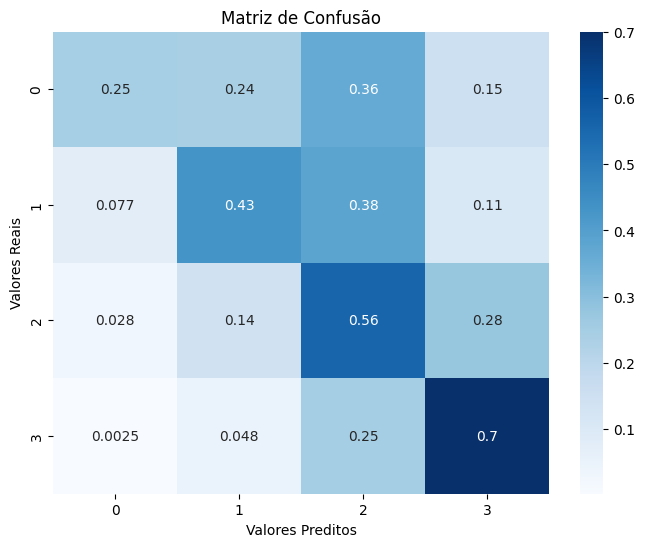

In [99]:
cm = confusion_matrix(y_test, ensemble_predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()